## Benchmark loading CELLxGENE Census data in Pytorch

Run this notebook via [Papermill](https://papermill.readthedocs.io/en/latest/) / the [`execute-nb`](https://github.com/ryan-williams/arrayloader-benchmarks/blob/main/execute-nb) wrapper

```bash
./execute-nb us-east-1  # from a g4dn.8xlarge in us-east-1
./execute-nb us-west-2  # from a g4dn.8xlarge in us-west-2
./execute-nb local-nvme -p census_uri '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'
./execute-nb subset-nvme -p experiment_uri '/mnt/nvme/census-benchmark_2:7' -p n_vars 0  # 20k vars already sliced
./execute-nb subset-gp3 -p experiment_uri 'data/census-benchmark_2:7' -p n_vars 0  # 20k vars already sliced
```
See [README](https://github.com/ryan-williams/arrayloader-benchmarks?tab=readme-ov-file#census-timing-vs-data-locality) for more info.

**⚠️ This notebook was run with a modified `cellxgene_census` library; see [`main...ryan-williams:cellxgene-census`](https://github.com/chanzuckerberg/cellxgene-census/compare/main...ryan-williams:cellxgene-census:stats?expand=1) ⚠️**

In [1]:
from benchmark import *
from utils import *

from cellxgene_census.experimental.ml import ExperimentDataPipe, experiment_dataloader
from cellxgene_census.experimental.ml.pytorch import pytorch_logger
import torch
from torch.utils.data import DataLoader
torch.ones(2).cuda();

### [Papermill](https://papermill.readthedocs.io/en/latest/) params:

In [2]:
# Set this to read from a local path
experiment_uri = 'data/census-benchmark_2:7'

# None ⟹ fetch from S3
census_uri = None
#census_uri = '/mnt/nvme/s3/cellxgene-census-public-us-west-2/cell-census/2023-12-15/soma'
census_version = "2023-12-15"

# By default:
# - `subset` if `experiment_uri` is a local path
# - `local` if `census_uri` is a local path
# - current (EC2 instance) region if `census_uri` is None (e.g. `us-east-1`, `us-west-2`)
name = 'subset-gp3-dbg'

collection_id = '283d65eb-dd53-496d-adb7-7570c7caa443'
# Slice datasets from `collection_id`
start = 2
end = 7

n_epochs = 1
batch_size = 1024

# Defaults to 20_000 when fetching from S3. Local subsets (when `experiment_uri` is set)
# are assumed to have already been var-sliced.
n_vars = None

soma_chunk_size = 10_000
gc_freq: Optional[int] = None  # When set, run `gc.collect()` every `gc_freq` batches
exclude_first_batch = True
progress_bar = True
torch_log_level = "DEBUG"

# Plot configs
ann_cutoff = .5  # Annotate plot with values for batch timings greater than this threshold
log_plot = False
width = 1200
height = 700

In [3]:
# Parameters
name = "subset-gp3-dbg"
progress_bar = False


In [4]:
pytorch_logger.setLevel(torch_log_level)

In [5]:
if experiment_uri:
    err(f"Loading experiment {experiment_uri}")
    with profile('open'):
        experiment = Experiment.open(experiment_uri)
    obs_query = None
    var_query = None
    if name is None:
        scheme = urlparse(experiment_uri).scheme
        if is_local(experiment_uri):
            name = 'subset'
else:
    if not census_uri:
        census_uri = None
    
    if name is None:
        if census_uri and is_local(census_uri):
            name = 'local'
        else:
            name = get_region()
    
    err(f"Loading census ({name})")

    with profile('open_soma'):
        census = cellxgene_census.open_soma(uri=census_uri, census_version=census_version)
    
    datasets = get_dataset_ids(census, collection_id, 'datasets')
    err(f"{len(datasets)} datasets: {datasets[:10]}")
    
    experiment = census["census_data"]["homo_sapiens"]
    ds = datasets[slice(start, end)]
    datasets_query = "dataset_id in " + str(ds)
    obs_query = AxisQuery(value_filter=datasets_query)
    if n_vars is None:
        n_vars = 20_000
    var_query = AxisQuery(coords=(slice(n_vars - 1),)) if n_vars else None

if not name:
    raise ValueError("`name` not set")

experiment

Loading experiment data/census-benchmark_2:7


<Experiment 'data/census-benchmark_2:7' (open for 'r') (2 items)
    'obs': 'file:///home/ec2-user/c/tiledb/arrayloader-benchmarks/data/census-benchmark_2:7/obs' (unopened)
    'ms': 'file:///home/ec2-user/c/tiledb/arrayloader-benchmarks/data/census-benchmark_2:7/ms' (unopened)>

In [6]:
%%time
with profile('get_exp_datapipe'):
    experiment_datapipe = ExperimentDataPipe(
        experiment,
        measurement_name="RNA",
        X_name="raw",
        obs_query=obs_query,
        var_query=var_query,
        batch_size=batch_size,
        shuffle=True,
        soma_chunk_size=soma_chunk_size,
    )
    loader = experiment_dataloader(experiment_datapipe)
exp = Exp(experiment_datapipe, loader)
exp

CPU times: user 4.16 ms, sys: 53 µs, total: 4.22 ms
Wall time: 3.86 ms


Exp(datapipe=ExperimentDataPipe, loader=<torch.utils.data.dataloader.DataLoader object at 0x7f1d4e350e50>)

In [7]:
%%time
print(f"Data shape: {exp.datapipe.shape}, pid {os.getpid()}")

Initializing ExperimentDataPipe


Initializing encoders


Data shape: (133790, 20000), pid 22197
CPU times: user 56.5 ms, sys: 44 ms, total: 100 ms
Wall time: 39.1 ms


## Run benchmark

In [8]:
%%time
epochs = []
for epoch in range(n_epochs):
    with profile(f'benchmark-epoch{epoch}'):
        epoch = benchmark(
            exp,
            batch_size=batch_size,
            gc_freq=gc_freq,
            exclude_first_batch=exclude_first_batch,
            progress_bar=progress_bar,
        )
    epochs.append(epoch)

results = Results(
    census=Method('census', epochs),
)

Using self.soma_chunk_size=10000


Shuffling 133790 obs joinids into 14 chunks of 10000


Process 22197 handling partition 1 of 1, partition_size=133790


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=1910788096, vms=26120880128, shared=544272384, text=3342336, lib=0, data=10920411136, dirty=0, uss=1512308736, pss=1702934528, swap=0), svmem(total=133636747264, available=124163624960, percent=7.1, used=8199553024, free=120514658304, active=9177305088, inactive=2553475072, buffers=2138112, cached=4920397824, shared=25935872, slab=493428736), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=1913974784, vms=26152345600, shared=545521664, text=3342336, lib=0, data=10964938752, dirty=0, uss=1515499520, pss=1706657792, swap=0), svmem(total=133636747264, available=124162969600, percent=7.1, used=8200208384, free=120514002944, active=9179320320, inactive=2553475072, buffers=2138112, cached=4920397824, shared=25935872, slab=492888064), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=24919121, elapsed=0:00:03.146154


Retrieved SOMA chunk totals: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=24919121, elapsed=0:00:03.146154, gc_elapsed=0:00:00.145923


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=3296399360, vms=33357520896, shared=547536896, text=3342336, lib=0, data=17181282304, dirty=0, uss=2899619840, pss=3091524608, swap=0), svmem(total=133636747264, available=122775375872, percent=8.1, used=9587765248, free=119126351872, active=10567110656, inactive=2553495552, buffers=2138112, cached=4920492032, shared=25935872, slab=492363776), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3296399360, vms=33357520896, shared=547536896, text=3342336, lib=0, data=17181282304, dirty=0, uss=2899619840, pss=3091524608, swap=0), svmem(total=133636747264, available=122775375872, percent=8.1, used=9587765248, free=119126351872, active=10567110656, inactive=2553495552, buffers=2138112, cached=4920492032, shared=25935872, slab=492363776), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=25249271, elapsed=0:00:03.345071


Retrieved SOMA chunk totals: self.n_soma_chunks=2, self.n_obs=19114, self.nnz=50168392, elapsed=0:00:06.491225, gc_elapsed=0:00:00.293561


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=6122147840, vms=38346678272, shared=547536896, text=3342336, lib=0, data=21909213184, dirty=0, uss=5726658560, pss=5918563328, swap=0), svmem(total=133636747264, available=119941750784, percent=10.2, used=12421390336, free=116292726784, active=13394509824, inactive=2553495552, buffers=2138112, cached=4920492032, shared=25935872, slab=492384256), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4319027200, vms=34495897600, shared=547536896, text=3342336, lib=0, data=18058432512, dirty=0, uss=3923537920, pss=4115442688, swap=0), svmem(total=133636747264, available=121745219584, percent=8.9, used=10617921536, free=118096195584, active=11592380416, inactive=2553495552, buffers=2138112, cached=4920492032, shared=25935872, slab=492384256), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=35898436, elapsed=0:00:04.447192


Retrieved SOMA chunk totals: self.n_soma_chunks=3, self.n_obs=28670, self.nnz=86066828, elapsed=0:00:10.938417, gc_elapsed=0:00:00.478800


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=6341459968, vms=39118716928, shared=547536896, text=3342336, lib=0, data=22415634432, dirty=0, uss=5947101184, pss=6139005952, swap=0), svmem(total=133636747264, available=119719473152, percent=10.4, used=12643663872, free=116070449152, active=13613981696, inactive=2553495552, buffers=2138112, cached=4920496128, shared=25935872, slab=492445696), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4155195392, vms=35035770880, shared=547536896, text=3342336, lib=0, data=18332688384, dirty=0, uss=3760726016, pss=3952630784, swap=0), svmem(total=133636747264, available=121908023296, percent=8.8, used=10455113728, free=118258999296, active=11428528128, inactive=2553495552, buffers=2138112, cached=4920496128, shared=25935872, slab=492445696), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=27197660, elapsed=0:00:03.266611


Retrieved SOMA chunk totals: self.n_soma_chunks=4, self.n_obs=38226, self.nnz=113264488, elapsed=0:00:14.205028, gc_elapsed=0:00:00.677487


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5008154624, vms=38878949376, shared=547536896, text=3342336, lib=0, data=21841301504, dirty=0, uss=4613566464, pss=4805471232, swap=0), svmem(total=133636747264, available=121056493568, percent=9.4, used=11306545152, free=117407358976, active=12281024512, inactive=2553495552, buffers=2138112, cached=4920705024, shared=25935872, slab=492576768), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3393581056, vms=34969288704, shared=547536896, text=3342336, lib=0, data=17931640832, dirty=0, uss=2998808576, pss=3190713344, swap=0), svmem(total=133636747264, available=122672529408, percent=8.2, used=9690509312, free=119023394816, active=10666176512, inactive=2553495552, buffers=2138112, cached=4920705024, shared=25935872, slab=492576768), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=16207697, elapsed=0:00:02.316467


Retrieved SOMA chunk totals: self.n_soma_chunks=5, self.n_obs=47782, self.nnz=129472185, elapsed=0:00:16.521495, gc_elapsed=0:00:00.849697


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=4126281728, vms=38844731392, shared=547536896, text=3342336, lib=0, data=21539188736, dirty=0, uss=3717046272, pss=3908951040, swap=0), svmem(total=133636747264, available=121937195008, percent=8.8, used=10425843712, free=118288060416, active=11398922240, inactive=2553495552, buffers=2138112, cached=4920705024, shared=25935872, slab=492544000), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3274473472, vms=35205582848, shared=547536896, text=3342336, lib=0, data=17900040192, dirty=0, uss=2880159744, pss=3072064512, swap=0), svmem(total=133636747264, available=122789400576, percent=8.1, used=9573638144, free=119140265984, active=10547605504, inactive=2553495552, buffers=2138112, cached=4920705024, shared=25935872, slab=492544000), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=14032495, elapsed=0:00:01.932357


Retrieved SOMA chunk totals: self.n_soma_chunks=6, self.n_obs=57338, self.nnz=143504680, elapsed=0:00:18.453853, gc_elapsed=0:00:01.023695


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5203943424, vms=39574450176, shared=547536896, text=3342336, lib=0, data=22005649408, dirty=0, uss=4809691136, pss=5001595904, swap=0), svmem(total=133636747264, available=120861077504, percent=9.6, used=11502075904, free=117212057600, active=12477214720, inactive=2553495552, buffers=2138112, cached=4920475648, shared=25935872, slab=492306432), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4046082048, vms=36015894528, shared=547536896, text=3342336, lib=0, data=18447093760, dirty=0, uss=3651829760, pss=3843734528, swap=0), svmem(total=133636747264, available=122020311040, percent=8.7, used=10342842368, free=118371291136, active=11319365632, inactive=2553495552, buffers=2138112, cached=4920475648, shared=25935872, slab=492306432), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=34774431, elapsed=0:00:04.336838


Retrieved SOMA chunk totals: self.n_soma_chunks=7, self.n_obs=66895, self.nnz=178279111, elapsed=0:00:22.790690, gc_elapsed=0:00:01.204337


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=6239596544, vms=40119730176, shared=547536896, text=3342336, lib=0, data=22350606336, dirty=0, uss=5845864448, pss=6037769216, swap=0), svmem(total=133636747264, available=119823859712, percent=10.3, used=12539277312, free=116174823424, active=13512855552, inactive=2553495552, buffers=2138112, cached=4920508416, shared=25935872, slab=492314624), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4105547776, vms=36063768576, shared=547536896, text=3342336, lib=0, data=18294644736, dirty=0, uss=3711672320, pss=3903577088, swap=0), svmem(total=133636747264, available=121960177664, percent=8.7, used=10402959360, free=118311141376, active=11379138560, inactive=2553495552, buffers=2138112, cached=4920508416, shared=25935872, slab=492314624), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=27269678, elapsed=0:00:03.307138


Retrieved SOMA chunk totals: self.n_soma_chunks=8, self.n_obs=76452, self.nnz=205548789, elapsed=0:00:26.097829, gc_elapsed=0:00:01.405164


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=6086250496, vms=40038100992, shared=547536896, text=3342336, lib=0, data=22269591552, dirty=0, uss=5693616128, pss=5885520896, swap=0), svmem(total=133636747264, available=119976636416, percent=10.2, used=12386500608, free=116327600128, active=13361082368, inactive=2553495552, buffers=2138112, cached=4920508416, shared=25935872, slab=492314624), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4328157184, vms=36144975872, shared=547536896, text=3342336, lib=0, data=18376466432, dirty=0, uss=3935522816, pss=4127427584, swap=0), svmem(total=133636747264, available=121736880128, percent=8.9, used=10626256896, free=118087843840, active=11603505152, inactive=2553495552, buffers=2138112, cached=4920508416, shared=25935872, slab=492314624), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=33892022, elapsed=0:00:04.247843


Retrieved SOMA chunk totals: self.n_soma_chunks=9, self.n_obs=86008, self.nnz=239440811, elapsed=0:00:30.345672, gc_elapsed=0:00:01.597277


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5571883008, vms=40480260096, shared=547536896, text=3342336, lib=0, data=22711750656, dirty=0, uss=5163794432, pss=5355699200, swap=0), svmem(total=133636747264, available=120493383680, percent=9.8, used=11869757440, free=116844335104, active=12845789184, inactive=2553520128, buffers=2138112, cached=4920516608, shared=25935872, slab=492331008), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3909181440, vms=36445474816, shared=547536896, text=3342336, lib=0, data=18676965376, dirty=0, uss=3499106304, pss=3691011072, swap=0), svmem(total=133636747264, available=122157711360, percent=8.6, used=10205429760, free=118508662784, active=11183075328, inactive=2553520128, buffers=2138112, cached=4920516608, shared=25935872, slab=492331008), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=17489698, elapsed=0:00:02.384176


Retrieved SOMA chunk totals: self.n_soma_chunks=10, self.n_obs=95564, self.nnz=256930509, elapsed=0:00:32.729848, gc_elapsed=0:00:01.785699


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5304655872, vms=40403095552, shared=547536896, text=3342336, lib=0, data=22634586112, dirty=0, uss=4912459776, pss=5104364544, swap=0), svmem(total=133636747264, available=120753618944, percent=9.6, used=11609518080, free=117104570368, active=12580093952, inactive=2553520128, buffers=2138112, cached=4920520704, shared=25935872, slab=492412928), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3975782400, vms=36736323584, shared=547536896, text=3342336, lib=0, data=18967814144, dirty=0, uss=3583553536, pss=3775458304, swap=0), svmem(total=133636747264, available=122083069952, percent=8.6, used=10280067072, free=118434021376, active=11251556352, inactive=2553520128, buffers=2138112, cached=4920520704, shared=25935872, slab=492412928), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=31183978, elapsed=0:00:03.835820


Retrieved SOMA chunk totals: self.n_soma_chunks=11, self.n_obs=105121, self.nnz=288114487, elapsed=0:00:36.565668, gc_elapsed=0:00:01.960691


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5526106112, vms=40518467584, shared=547536896, text=3342336, lib=0, data=22749958144, dirty=0, uss=5133979648, pss=5325884416, swap=0), svmem(total=133636747264, available=120534126592, percent=9.8, used=11829014528, free=116885073920, active=12804132864, inactive=2553524224, buffers=2138112, cached=4920520704, shared=25935872, slab=492404736), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=3605041152, vms=36452864000, shared=547536896, text=3342336, lib=0, data=18684354560, dirty=0, uss=3212865536, pss=3404770304, swap=0), svmem(total=133636747264, available=122458116096, percent=8.4, used=9905025024, free=118809063424, active=10882293760, inactive=2553524224, buffers=2138112, cached=4920520704, shared=25935872, slab=492404736), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=19339142, elapsed=0:00:02.473800


Retrieved SOMA chunk totals: self.n_soma_chunks=12, self.n_obs=114677, self.nnz=307453629, elapsed=0:00:39.039468, gc_elapsed=0:00:02.143551


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=5571092480, vms=40515334144, shared=547536896, text=3342336, lib=0, data=22747467776, dirty=0, uss=5179809792, pss=5371714560, swap=0), svmem(total=133636747264, available=120482189312, percent=9.8, used=11880955904, free=116833140736, active=12851286016, inactive=2553524224, buffers=2138112, cached=4920512512, shared=25935872, slab=492376064), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4168708096, vms=36818927616, shared=547536896, text=3342336, lib=0, data=19051061248, dirty=0, uss=3777425408, pss=3969330176, swap=0), svmem(total=133636747264, available=121889992704, percent=8.8, used=10473152512, free=118240944128, active=11444867072, inactive=2553524224, buffers=2138112, cached=4920512512, shared=25935872, slab=492376064), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9557, self.nnz=33919521, elapsed=0:00:04.223256


Retrieved SOMA chunk totals: self.n_soma_chunks=13, self.n_obs=124234, self.nnz=341373150, elapsed=0:00:43.262724, gc_elapsed=0:00:02.327336


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=6224445440, vms=40741691392, shared=547536896, text=3342336, lib=0, data=22974623744, dirty=0, uss=5831786496, pss=6023691264, swap=0), svmem(total=133636747264, available=119838908416, percent=10.3, used=12529434624, free=116184555520, active=13494349824, inactive=2558771200, buffers=2138112, cached=4920619008, shared=25935872, slab=492453888), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=4193677312, vms=36706242560, shared=547536896, text=3342336, lib=0, data=18939174912, dirty=0, uss=3800899584, pss=3992804352, swap=0), svmem(total=133636747264, available=121872396288, percent=8.8, used=10495946752, free=118218043392, active=11463516160, inactive=2558771200, buffers=2138112, cached=4920619008, shared=25935872, slab=492453888), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


Retrieved SOMA chunk: self.n_soma_chunks=1, self.n_obs=9556, self.nnz=29214437, elapsed=0:00:03.507206


Retrieved SOMA chunk totals: self.n_soma_chunks=14, self.n_obs=133790, self.nnz=370587587, elapsed=0:00:46.769930, gc_elapsed=0:00:02.522192


Retrieving next SOMA chunk...


gc:  pre=(pfullmem(rss=4019949568, vms=36859674624, shared=547536896, text=3342336, lib=0, data=19092606976, dirty=0, uss=3626958848, pss=3818863616, swap=0), svmem(total=133636747264, available=122044379136, percent=8.7, used=10323963904, free=118390026240, active=11289751552, inactive=2558771200, buffers=2138112, cached=4920619008, shared=25935872, slab=492421120), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=2708803584, vms=32919130112, shared=547536896, text=3342336, lib=0, data=15152062464, dirty=0, uss=2315812864, pss=2507717632, swap=0), svmem(total=133636747264, available=123356798976, percent=7.7, used=9011544064, free=119702446080, active=9978802176, inactive=2558771200, buffers=2138112, cached=4920619008, shared=25935872, slab=492421120), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc:  pre=(pfullmem(rss=2445729792, vms=32890789888, shared=547536896, text=3342336, lib=0, data=15123722240, dirty=0, uss=2052730880, pss=2244635648, swap=0), svmem(total=133636747264, available=123619610624, percent=7.5, used=8748732416, free=119965257728, active=9716023296, inactive=2558771200, buffers=2138112, cached=4920619008, shared=25935872, slab=492421120), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


gc: post=(pfullmem(rss=2445729792, vms=32890789888, shared=547536896, text=3342336, lib=0, data=15123722240, dirty=0, uss=2052730880, pss=2244635648, swap=0), svmem(total=133636747264, available=123620110336, percent=7.5, used=8748232704, free=119965757440, active=9715703808, inactive=2558771200, buffers=2138112, cached=4920619008, shared=25935872, slab=492421120), sswap(total=0, used=0, free=0, percent=0.0, sin=0, sout=0))


max process memory usage=5.539 GiB


time per sample: 336.84 μs
samples per sec: 2968.77 samples/sec
CPU times: user 1min 13s, sys: 36.8 s, total: 1min 50s
Wall time: 48.4 s


In [9]:
exp_stats = experiment_datapipe.stats()
checkpoints_df = exp_stats.checkpoints_df()
checkpoints_df

,obs_joinids_chunk,obs_batch,obs_batch_reindex,scipy_iter,X_batch
0,0.000693,0.188012,0.001238,0.002884,2.953273
1,0.000371,0.035040,0.000618,0.003097,3.305917
2,0.000451,0.021342,0.000712,0.003186,4.421475
3,0.000434,0.021039,0.000574,0.003214,3.241325
4,0.000677,0.023094,0.000969,0.005238,2.286462
5,0.000469,0.020635,0.000663,0.003058,1.907506
6,0.000490,0.024412,0.000858,0.004644,4.306403
7,0.000600,0.023950,0.000815,0.004395,3.277352
8,0.000352,0.022572,0.000579,0.003273,4.221043
9,0.000418,0.021219,0.000644,0.003651,2.358221


## CxG `pytorch.py` latency
Total latency from various chunks in [CxG `_ObsAndXSOMAIterator`](https://github.com/ryan-williams/cellxgene-census/blob/a0fa2449a9f9858edd3befee3c9fb46f84c2cf44/api/python/cellxgene_census/src/cellxgene_census/experimental/ml/pytorch.py#L162-L212):

In [10]:
checkpoints_df.sum()

obs_joinids_chunk     0.006852
obs_batch             0.498888
obs_batch_reindex     0.010677
scipy_iter            0.054791
X_batch              46.198327
dtype: float64

## `tiledbsoma` latency
Measured by `tiledbsoma_stats_*`:

In [11]:
timers_df, counters_df = stats.dfs
timers_df['sum'].sum()

8.660273706

In [12]:
timers_df.groupby(['source', 'name'])['sum'].sum()

source      name   
tiledb      open       0.000368
tiledbsoma  X_batch    8.659564
            open       0.000342
Name: sum, dtype: float64

### `tiledb{,soma}` timer/counter DataFrames

In [13]:
timers_df

,key,avg,sum,num,name,source
0,Context.StorageManager.load_group_from_all_uris,0.000094,0.000094,1,open,tiledb
1,Context.StorageManager.load_group_details,0.000099,0.000099,1,open,tiledb
2,Context.StorageManager.group_open_for_reads,0.000100,0.000100,1,open,tiledb
3,Context.StorageManager.group_load_metadata_fro...,0.000075,0.000075,1,open,tiledb
4,Context.StorageManager.load_group_from_all_uris,0.000090,0.000090,1,open,tiledbsoma
...,...,...,...,...,...,...
381,Context.StorageManager.Query.Reader.create_res...,0.000895,0.000895,1,X_batch,tiledbsoma
382,Context.StorageManager.Query.Reader.copy_fixed...,0.013741,0.041224,3,X_batch,tiledbsoma
383,Context.StorageManager.Query.Reader.compute_ti...,0.005635,0.005635,1,X_batch,tiledbsoma
384,Context.StorageManager.Query.Reader.compute_re...,0.001076,0.039825,37,X_batch,tiledbsoma


In [14]:
counters_df

,key,num,name,source
0,Context.StorageManager.read_unfiltered_byte_num,262,open,tiledb
1,Context.StorageManager.read_group_size,70,open,tiledb
2,Context.StorageManager.group_read_group_meta_size,192,open,tiledb
3,Context.StorageManager.VFS.read_ops_num,6,open,tiledb
4,Context.StorageManager.VFS.read_byte_num,333,open,tiledb
...,...,...,...,...
288,Context.StorageManager.Query.Reader.dim_num,2,X_batch,tiledbsoma
289,Context.StorageManager.Query.Reader.dim_fixed_num,2,X_batch,tiledbsoma
290,Context.StorageManager.Query.Reader.cell_num,30800000,X_batch,tiledbsoma
291,Context.StorageManager.Query.Reader.attr_num,1,X_batch,tiledbsoma


## Save batch timings, `tiledb{,soma}` stats

In [15]:
results_json_path = f'results/{name}.json'
with open(results_json_path, 'w') as f:
    json.dump(asdict(results), f, indent=2)
    err(f"Saved results to {results_json_path}")

Saved results to results/subset-gp3-dbg.json


In [16]:
makedirs('tdb')
timers_path = f'tdb/{name}-timers.csv'
timers_df.sort_values('key').to_csv(timers_path)
counters_path = f'tdb/{name}-counters.csv'
counters_df.sort_values('key').to_csv(counters_path)

In [17]:
# with open(results_json_path, 'r') as f:
#     results = Results(**json.load(f))

## Plot batch timings

In [18]:
method = 'census'
epoch = 0
batches = getattr(results, 'census').epochs[epoch].batches
df = pd.DataFrame(batches)
df['gc'] = df['gc'].fillna(nan)
if df.gc.isna().all():
    df = df.drop(columns='gc')
df.index.name = 'idx'
df = df.reset_index()
df

/tmp/ipykernel_22197/2254310219.py:5: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['gc'] = df['gc'].fillna(nan)


,idx,batch
0,0,0.184612
1,1,0.159008
2,2,0.157543
3,3,0.199360
4,4,0.159846
...,...,...
125,125,0.108683
126,126,0.109016
127,127,0.109019
128,128,0.109385


In [19]:
ann = df[df.batch > ann_cutoff] if ann_cutoff else df[[]]
ann

,idx,batch
8,8,2.080871
17,17,3.109007
26,26,1.678117
36,36,0.858071
45,45,0.699237
54,54,3.014797
64,64,1.762340
73,73,2.812306
82,82,0.841288
92,92,2.536987


In [20]:
pc

PlotConfigs(fmt='fig', w=1200, h=800, save=[], v=True, i=None, dir=None, grid='#ccc', bg='white')

Saving: img/census-subset-gp3-dbg.png


Returning IPython Image


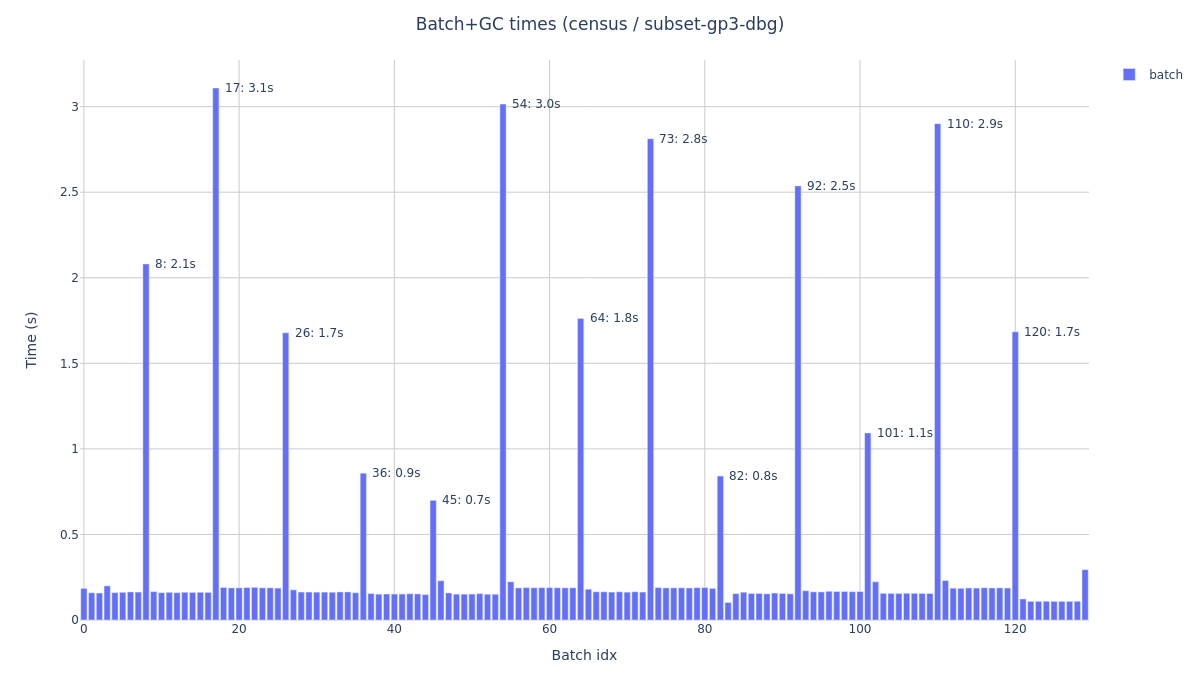

In [21]:
fig = px.bar(
    df.set_index('idx')[['batch', *(['gc'] if 'gc' in df else [])]],
    barmode='stack',
    labels={
        'idx': 'Batch idx',
        'variable': '',
        'value': 'Time (s)',
    },
    log_y=log_plot,
).update_layout(
    title=dict(text=f'Batch+GC times ({method} / {name})'),
).update_xaxes(
    range=(-.5, len(df) - 1 + .5),
)

if not ann.empty:
    anns = ann.set_index('idx').batch.to_dict().items()
    for idx, batch in anns:
        fig.add_annotation(
            x=idx, y=log10(batch) if log_plot else batch,
            showarrow=False,
            text=f'{idx}: {batch:.1f}s',
            xshift=7,
            xanchor='left',
        )

plot(fig, f'census-{name}', fmt='png', save=['png'], w=width, h=height, dir='img',)